In [ ]:
!pip install gym

In [ ]:
!pip install plotly

In [ ]:
# !pip install pygame
# !pip uninstall pygame

In [ ]:
# !pip install gym[toy_text]==0.26.*
# !pip install gym[toy_text]==0.26.2
!pip install gym[box2d]==0.26.0 pyglet==1.5.27 pyvirtualdisplay

In [ ]:
!pip install pyvirtualdisplay
!pip install pyglet==1.5.27

# Double DQN

Episode: 10, Epsilon: 0.0101, Score: 113.21
Episode: 20, Epsilon: 0.0100, Score: 118.69
Episode: 30, Epsilon: 0.0100, Score: 121.36
Episode: 40, Epsilon: 0.0100, Score: 99.18
Episode: 50, Epsilon: 0.0100, Score: 116.47
Episode: 60, Epsilon: 0.0100, Score: 121.37
Episode: 70, Epsilon: 0.0100, Score: 116.98
Episode: 80, Epsilon: 0.0100, Score: 118.99
Episode: 90, Epsilon: 0.0100, Score: 116.83
Episode: 100, Epsilon: 0.0100, Score: 130.93


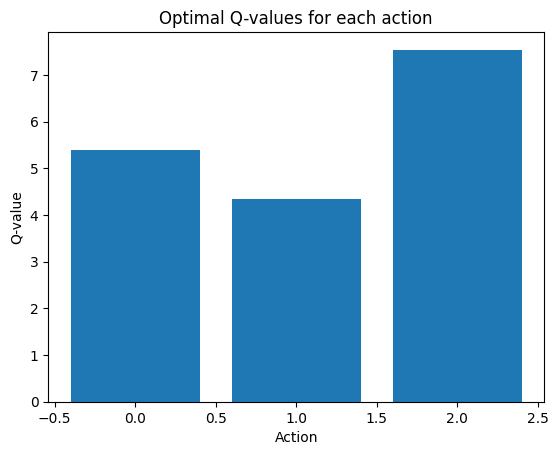

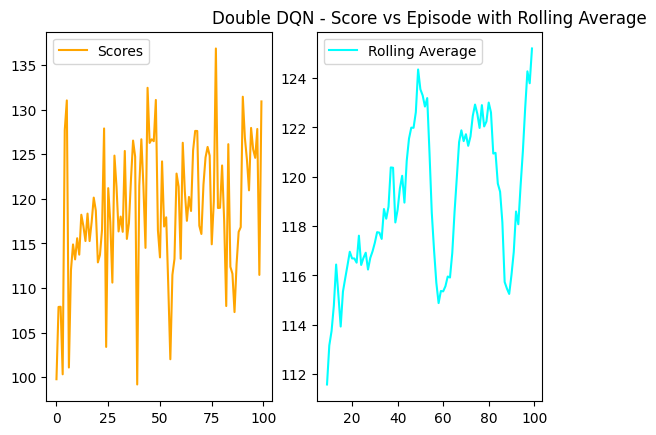

In [ ]:
# Run this

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import plotly.graph_objects as go
import matplotlib.pyplot as plt

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# https://www.bing.com/search?pglt=43&q=nn.Module&cvid=3e8744507f7d432fb59a2a95abeccad8&gs_lcrp=
# EgZjaHJvbWUyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBBFGDzSAQcxNDhqMGoxqAIAsAIA&FORM=ANNTA1&PC=DCTS

# Define Double DQN Model Architecture
class DoubleDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes):
        super(DoubleDQN, self).__init__()
        self.hidden1 = nn.Linear(state_size, hidden_sizes[0])
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.output = nn.Linear(hidden_sizes[1], action_size)

    def forward(self, state):
        x = torch.relu(self.hidden1(state))
        x = torch.relu(self.hidden2(x))
        return self.output(x)

# Function to visualize Q-values predicted by the policy network
def visualize_q_values(policy_net, state):
    with torch.no_grad():
        q_values = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    action_values = q_values.numpy()[0]
    actions = np.arange(len(action_values))

    plt.bar(actions, action_values)
    plt.title("Optimal Q-values for each action")
    plt.ylabel("Q-value")
    plt.xlabel("Action")
    plt.show()

    # fig = go.Figure(data=[go.Bar(x=actions, y=action_values)])
    # fig.update_layout(title='Q-values Predicted by Policy Network',
    #                   xaxis_title='Action',
    #                   yaxis_title='Q-value')
    # fig.show()

# # Function to compare parameters of policy network and target network
# def compare_networks(policy_net, target_net):
#     policy_params = np.concatenate([param.data.numpy().flatten() for param in policy_net.parameters()])
#     target_params = np.concatenate([param.data.numpy().flatten() for param in target_net.parameters()])

#     fig = go.Figure()
#     fig.add_trace(go.Scatter(y=policy_params, mode='lines', name='Policy Network', line=dict(color='blue', width=2), opacity=1))
#     fig.add_trace(go.Scatter(y=target_params, mode='lines', name='Target Network', line=dict(color='red', width=2), opacity=0.5))

#     # Add vertical lines to indicate the separation between different layers
#     layer_sizes = [state_size] + hidden_sizes + [action_size]
#     param_count = 0
#     for size in layer_sizes[:-1]:
#         param_count += size * layer_sizes[layer_sizes.index(size) + 1]
#         fig.add_shape(type='line',
#                       x0=param_count, y0=policy_params.min(),
#                       x1=param_count, y1=policy_params.max(),
#                       line=dict(color='gray', width=1))

#     fig.update_layout(title='Comparison of Policy and Target Networks Parameters',
#                       xaxis_title='Parameter Index',
#                       yaxis_title='Parameter Value',
#                       legend=dict(x=0.8, y=0.9, bgcolor='rgba(255, 255, 255, 0.8)'))
#     fig.show()




# Set up the environment
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Reward Function
def reward_function(state, next_state):
    position = state[0]
    next_position = next_state[0]
    velocity = state[1]
    next_velocity = next_state[1]

    # Check if the episode is done
    if next_position >= 0.5:
        return 100  # Large positive reward for reaching the target position

    # Reward proportional to the change in position towards the target
    reward = (next_position - position) * 10

    # Additional reward for maintaining positive velocity
    if next_velocity > 0:
        reward += 1

    return reward

# Hyperparameters
batch_size = 64
gamma = 0.8
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.95
# epsilon = 0.9 # Only run if using linear epsilon decay
target_update_freq = 10
learning_rate = 0.01
memory_size = 10000
hidden_sizes = [100, 64]
num_episodes = 100
print_every = 10

# Create the Double DQN network and target network
policy_net = DoubleDQN(state_size, action_size, hidden_sizes)
target_net = DoubleDQN(state_size, action_size, hidden_sizes)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Define the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Define the replay memory
# https://docs.python.org/3/library/collections.html
memory = deque(maxlen=memory_size)

# Define the epsilon-greedy policy
def epsilon_greedy_policy(state, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).item()
    else:
        return random.randrange(action_size)

# Initialize lists to store scores and episode numbers
scores = []
episode_numbers = []

# Train the Double DQN agent
for episode in range(num_episodes):
    state = env.reset()

    # Epsilon decay stratergy
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay) # Non-linear decay
    # epsilon *= epsilon_decay # Linear decay

    done = False
    score = 0
    while not done:
        action = epsilon_greedy_policy(torch.tensor(state, dtype=torch.float32).unsqueeze(0), epsilon)
        next_state, _, done, _ = env.step(action)
        reward = reward_function(state, next_state)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        score += reward

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)
            states = torch.tensor(states, dtype=torch.float32)
            actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(next_states, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            expected_q_values = rewards + (1 - dones) * gamma * next_q_values

            loss = nn.MSELoss()(q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    scores.append(score)
    episode_numbers.append(episode)

    # Print episode number, epsilon, and score after every 'print_every' episodes
    if (episode + 1) % print_every == 0:
        print(f"Episode: {episode+1}, Epsilon: {epsilon:.4f}, Score: {score:.2f}")

# Visualize Q-values for a sample state
sample_state = env.observation_space.sample()
visualize_q_values(policy_net, sample_state)

# # Compare parameters of policy network and target network
# compare_networks(policy_net, target_net)

# # Plot the scores against episode numbers using Plotly
# fig = go.Figure(data=go.Scatter(x=episode_numbers, y=scores, mode='lines'))
# fig.update_layout(title='Double DQN - Score vs Episode',
#                   xaxis_title='Episode',
#                   yaxis_title='Score')
# fig.show()

# Calculate rolling average
window_size = 10  # Adjust the window size as needed
rolling_avg_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')

# # Plot the scores and rolling average against episode numbers using Plotly
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=episode_numbers, y=scores, mode='lines', name='Scores'))
# fig.add_trace(go.Scatter(x=episode_numbers[window_size - 1:], y=rolling_avg_scores, mode='lines', name='Rolling Average'))
# fig.update_layout(title='Double DQN - Score vs Episode with Rolling Average',
#                   xaxis_title='Episode',
#                   yaxis_title='Score',
#                   legend=dict(x=0.8, y=0.9, bgcolor='rgba(255, 255, 255, 0.8)'))
# fig.show()

fig, ax = plt.subplots(1, 2)
ax[0].plot(episode_numbers, scores, label = "Scores", color = "orange")
ax[1].plot(episode_numbers[window_size - 1:], rolling_avg_scores, label = "Rolling Average", color = "cyan")
ax[0].legend()
ax[1].legend()
plt.title("Double DQN - Score vs Episode with Rolling Average")
plt.show()

# import plotly.graph_objects as go

# fig = go.Figure(layout=dict(title="Double DQN - Score vs Episode with Rolling Average"))

# # Plot scores
# trace1 = go.Scatter(
#     x=episode_numbers,
#     y=scores,
#     mode="lines",
#     name="Scores",
#     line_color="orange",
# )

# # Plot rolling average scores (starting from window_size)
# trace2 = go.Scatter(
#     x=episode_numbers[window_size - 1:],
#     y=rolling_avg_scores,
#     mode="lines",
#     name="Rolling Average",
#     line_color="cyan",
# )

# # Add traces to the figure
# fig.add_trace(trace1)
# fig.add_trace(trace2)

# # Show legend
# fig.update_layout(legend=dict(yanchor="top", y=1.02, xanchor="right", x=1))

# fig.show()


# Close the environment
env.close()

# PER DQN

Episode: 10, Average Score: 106.46, Epsilon: 0.01
Episode: 20, Average Score: 116.25, Epsilon: 0.01
Episode: 30, Average Score: 117.17, Epsilon: 0.01
Episode: 40, Average Score: 116.27, Epsilon: 0.01
Episode: 50, Average Score: 139.50, Epsilon: 0.01
Episode: 60, Average Score: 139.86, Epsilon: 0.01
Episode: 70, Average Score: 145.36, Epsilon: 0.01
Episode: 80, Average Score: 152.87, Epsilon: 0.01
Episode: 90, Average Score: 147.60, Epsilon: 0.01
Episode: 100, Average Score: 181.70, Epsilon: 0.01


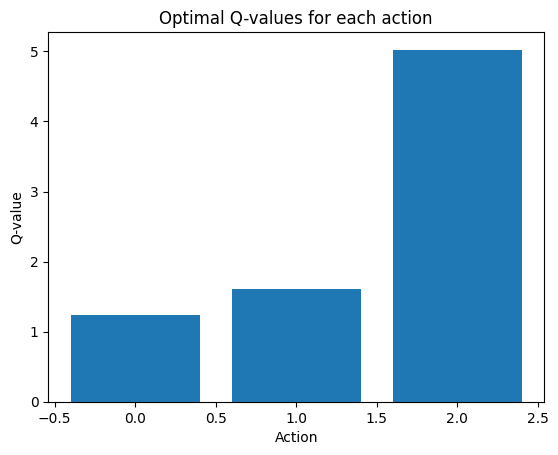

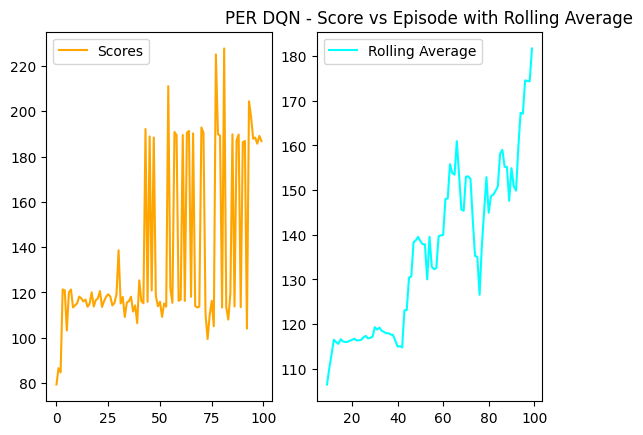

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple
import matplotlib.pyplot as plt
import plotly.graph_objects as go

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# https://pytorch.org/rl/stable/reference/generated/torchrl.data.PrioritizedReplayBuffer.html
# https://www.bing.com/search?pglt=43&q=nn.Module&cvid=3e8744507f7d432fb59a2a95abeccad8&gs_lcrp=
# EgZjaHJvbWUyBggAEEUYOTIGCAEQABhAMgYIAhAAGEAyBggDEAAYQDIGCAQQABhAMgYIBRAAGEAyBggGEAAYQDIGCAcQABhAMgYICBBFGDzSAQcxNDhqMGoxqAIAsAIA&FORM=ANNTA1&PC=DCTS

# Define the Prioritized Experience Replay buffer
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.pos] = (state, action, reward, next_state, done)
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        probs = prios ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        return samples, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

# Define the DQN network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes):
        super(DQN, self).__init__()
        self.hidden1 = nn.Linear(state_size, hidden_sizes[0])
        self.hidden2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        # self.hidden3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        # self.hidden4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        # self.hidden5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.output = nn.Linear(hidden_sizes[1], action_size)

    def forward(self, state):
        x = torch.relu(self.hidden1(state))
        x = torch.relu(self.hidden2(x))
        # x = torch.relu(self.hidden3(x))
        # x = torch.relu(self.hidden4(x))
        # x = torch.relu(self.hidden5(x))
        return self.output(x)

# Reward Function
def reward_function(state, next_state):
    position = state[0]
    next_position = next_state[0]
    velocity = state[1]
    next_velocity = next_state[1]

    # Check if the episode is done
    if next_position >= 0.5:
        return 100  # Large positive reward for reaching the target position

    # Reward proportional to the change in position towards the target
    reward = (next_position - position) * 10

    # Additional reward for maintaining positive velocity
    if next_velocity > 0:
        reward += 1

    return reward

# Function to visualize Q-values predicted by the policy network
def visualize_q_values(policy_net, state):
    with torch.no_grad():
        q_values = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    action_values = q_values.numpy()[0]
    actions = np.arange(len(action_values))
    plt.bar(actions, action_values)
    plt.title("Optimal Q-values for each action")
    plt.ylabel("Q-value")
    plt.xlabel("Action")

    # fig = go.Figure(data=[go.Bar(x=actions, y=action_values)])
    # fig.update_layout(title='Q-values Predicted by Policy Network',
    #                   xaxis_title='Action',
    #                   yaxis_title='Q-value')
    # fig.show()

# # Function to compare parameters of policy network and target network
# def compare_networks(policy_net, target_net):
#     policy_params = np.concatenate([param.data.numpy().flatten() for param in policy_net.parameters()])
#     target_params = np.concatenate([param.data.numpy().flatten() for param in target_net.parameters()])

# #     fig = go.Figure()
# #     fig.add_trace(go.Scatter(y=policy_params, mode='lines', name='Policy Network', line=dict(color='rgba(0, 0, 255, 0.8)', width=2)))
# #     fig.add_trace(go.Scatter(y=target_params, mode='lines', name='Target Network', line=dict(color='rgba(255, 0, 0, 0.6)', width=2)))
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(y=policy_params, mode='lines', name='Policy Network', line=dict(color='blue', width=2), opacity=1))
#     fig.add_trace(go.Scatter(y=target_params, mode='lines', name='Target Network', line=dict(color='red', width=2), opacity=0.3))

#     # Add vertical lines to indicate the separation between different layers
#     layer_sizes = [state_size] + hidden_sizes + [action_size]
#     param_count = 0
#     for size in layer_sizes[:-1]:
#         param_count += size * layer_sizes[layer_sizes.index(size) + 1]
#         fig.add_shape(type='line',
#                       x0=param_count, y0=policy_params.min(),
#                       x1=param_count, y1=policy_params.max(),
#                       line=dict(color='gray', width=1, dash='dot'))

#     fig.update_layout(title='Comparison of Policy and Target Networks Parameters',
#                       xaxis_title='Parameter Index',
#                       yaxis_title='Parameter Value',
#                       legend=dict(x=0.8, y=0.9, bgcolor='rgba(255, 255, 255, 0.8)'))
#     fig.show()


# Set up the environment
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Hyperparameters
batch_size = 64
gamma = 0.8
learning_rate = 0.0001
target_update_freq = 10
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.85
# epsilon = 0.9 # Use for linear decay rate
memory_size = 10000
alpha = 0.4
beta_start = 0.6
beta_frames = 50000
hidden_sizes = [100, 64]
num_episodes = 100
print_every = 10

# Create the PER buffer and DQN network
memory = PrioritizedReplayBuffer(memory_size, alpha)
policy_net = DQN(state_size, action_size, hidden_sizes)
target_net = DQN(state_size, action_size, hidden_sizes)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Define the optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Define the loss function
def loss_fn(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, batch_weights):
    batch_q_values = policy_net(batch_states).gather(1, batch_actions)
    batch_next_q_values = target_net(batch_next_states).max(1)[0].unsqueeze(1).detach()
    batch_expected_q_values = batch_rewards + (1 - batch_dones) * gamma * batch_next_q_values
    batch_weights_tensor = torch.FloatTensor(batch_weights).unsqueeze(1)
    loss = (batch_weights_tensor * (batch_q_values - batch_expected_q_values) ** 2).mean()
    return loss, batch_q_values, batch_expected_q_values

# Training loop
scores = []
episode_numbers = []
for episode in range(num_episodes):
    state = env.reset()
    score = 0
    done = False
    beta = min(1.0, beta_start + episode * (1.0 - beta_start) / beta_frames)

    # Epsilon decay rate stratergy
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay) # Non-lienar decay
    # epsilon *= epsilon_decay # Linear decay

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()

        next_state, _, done, _ = env.step(action)
        reward = reward_function(state, next_state)
        memory.add(state, action, reward, next_state, done)
        state = next_state
        score += reward

        if len(memory) >= batch_size:
            batch, batch_indices, batch_weights = memory.sample(batch_size, beta)
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = zip(*batch)
            batch_states = torch.FloatTensor(batch_states)
            batch_actions = torch.LongTensor(batch_actions).unsqueeze(1)
            batch_rewards = torch.FloatTensor(batch_rewards).unsqueeze(1)
            batch_next_states = torch.FloatTensor(batch_next_states)
            batch_dones = torch.FloatTensor(batch_dones).unsqueeze(1)

            loss, batch_q_values, batch_expected_q_values = loss_fn(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones, batch_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_priorities = (torch.abs(batch_q_values - batch_expected_q_values) + 1e-5).squeeze().detach().cpu().numpy()
            memory.update_priorities(batch_indices, batch_priorities)

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    scores.append(score)
    episode_numbers.append(episode)

    if (episode + 1) % print_every == 0:
        avg_score = np.mean(scores[-print_every:])
        print(f"Episode: {episode+1}, Average Score: {avg_score:.2f}, Epsilon: {epsilon:.2f}")

# Visualize Q-values for a sample state
sample_state = env.observation_space.sample()
visualize_q_values(policy_net, sample_state)

# # Compare parameters of policy network and target network
# compare_networks(policy_net, target_net)
# Plot the scores
# plt.plot(range(1, num_episodes+1), scores)
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.title('PER DQN - MountainCar')
# plt.show()

# Calculate rolling average
window_size = 10  # Adjust the window size as needed
rolling_avg_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')

# # Plot the scores and rolling average against episode numbers using Plotly
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=episode_numbers, y=scores, mode='lines', name='Scores'))
# fig.add_trace(go.Scatter(x=episode_numbers[window_size - 1:], y=rolling_avg_scores, mode='lines', name='Rolling Average'))
# fig.update_layout(title='Double DQN - Score vs Episode with Rolling Average',
#                   xaxis_title='Episode',
#                   yaxis_title='Score',
#                   legend=dict(x=0.8, y=0.9, bgcolor='rgba(255, 255, 255, 0.8)'))
# fig.show()

fig, ax = plt.subplots(1, 2)
ax[0].plot(episode_numbers, scores, label = "Scores", color = "orange")
ax[1].plot(episode_numbers[window_size - 1:], rolling_avg_scores, label = "Rolling Average", color = "cyan")
ax[0].legend()
ax[1].legend()
plt.title("PER DQN - Score vs Episode with Rolling Average")
plt.show()


env.close()

In the compare_networks() function, we plot the parameter values of the policy network and the target network. The parameters being plotted are the flattened values of all the learnable parameters (weights and biases) of each network.

Here's how the parameter values are obtained:

python
policy_params = np.concatenate([param.data.numpy().flatten() for param in policy_net.parameters()])
target_params = np.concatenate([param.data.numpy().flatten() for param in target_net.parameters()])


1. policy_net.parameters() and target_net.parameters() return iterables containing all the learnable parameters of the respective networks.

2. For each parameter tensor, we access its underlying data using param.data, convert it to a NumPy array using numpy(), and flatten it into a 1D array using flatten().

3. We then concatenate all the flattened parameter arrays into a single 1D array for each network using np.concatenate(). The resulting policy_params and target_params arrays contain the flattened parameter values of the policy network and target network, respectively.

The plot created by the compare_networks() function shows the parameter values of the policy network and target network along the y-axis, with each point on the x-axis representing a specific parameter index. The blue line represents the parameter values of the policy network, while the red line (slightly transparent) represents the parameter values of the target network.

The vertical lines added to the plot indicate the separation between different layers of the networks. The layer sizes are determined based on the input size (state_size), hidden layer sizes (hidden_sizes), and output size (action_size). The vertical lines help visualize the boundaries between different layers and provide a clearer understanding of the parameter distribution.

By plotting the parameter values of both networks, you can observe how the parameters of the policy network and target network differ during the training process. The target network's parameters are periodically updated with the policy network's parameters to stabilize the learning process. The plot allows you to visualize the convergence of the parameters over time.

Keep in mind that the specific parameter values plotted depend on the current state of the networks at the time the compare_networks() function is called. The parameter values will change as the networks are trained and updated throughout the training process.